### import libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from sklearn.cluster import KMeans
import random
from scipy.stats import skewnorm
import plotly.graph_objects as go
import plotly.io as pio
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option("max.columns", 30)
pd.set_option('display.max_columns', None)
pio.renderers
pio.renderers.default = 'svg'

### import zip code csv (AL, GA, MS, SC)

In [2]:
AL_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/zip_codes/AL_ZIPCODES.csv')
GA_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/zip_codes/GA_ZIPCODES.csv')
MS_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/zip_codes/MS_ZIPCODES.csv')
SC_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/zip_codes/SC_ZIPCODES.csv')
us_coordinate_lookup = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/USZIPCodes202204.csv')

### set num of clusters (stores)

In [3]:
# set num of stores
no_of_clusters = 6

### Create high-density counties where deer harvest numbers have been historically high

In [4]:
# Identify high-density counties
AL_HIGH_DENSITY_COUNTIES = ['TUSCALOOSA','BALDWIN','BARBOUR','CHEROKEE']
GA_HIGH_DENSITY_COUNTIES = ['WORTHY','BARTOW','LEE','DOUGHERTY']
MS_HIGH_DENSITY_COUNTIES = ['MADISON','HINDS','YAZOO']
SC_HIGH_DENSITY_COUNTIES = ['ANDERSON','BARNWELL']

# Exclude high-density counties from each state's DF
AL_ZIP_CODES = AL_ZIP_CODES[AL_ZIP_CODES['County Name'].isin(['AL_HIGH_DENSITY_COUNTIES']) == False]
GA_ZIP_CODES = GA_ZIP_CODES[GA_ZIP_CODES['County Name'].isin(['GA_HIGH_DENSITY_COUNTIES']) == False]
MS_ZIP_CODES = MS_ZIP_CODES[MS_ZIP_CODES['County Name'].isin(['MS_HIGH_DENSITY_COUNTIES']) == False]
SC_ZIP_CODES = SC_ZIP_CODES[SC_ZIP_CODES['County Name'].isin(['SC_HIGH_DENSITY_COUNTIES']) == False]

### Randomly generate deer harvest counts for each state (AL, GA, MS, SC)

In [5]:
# Generate random deer harvest count per zip code in AL (total 548k)
AL_ZIP_CODES['harvest_count'] = np.around(np.random.dirichlet(np.ones(AL_ZIP_CODES.shape[0]),size=10)[0], decimals = 15)
AL_ZIP_CODES['harvest_count'] = AL_ZIP_CODES['harvest_count'] * 388000
# Generate random deer harvest countper zip code in GA (total 652k)
GA_ZIP_CODES['harvest_count'] = np.around(np.random.dirichlet(np.ones(GA_ZIP_CODES.shape[0]),size=10)[0],decimals = 15)
GA_ZIP_CODES['harvest_count'] = GA_ZIP_CODES['harvest_count'] * 512000
# Generate random deer harvest count per zip code in MS (total 300k)
MS_ZIP_CODES['harvest_count'] = np.around(np.random.dirichlet(np.ones(MS_ZIP_CODES.shape[0]),size=10)[0], decimals = 15)
MS_ZIP_CODES['harvest_count'] = MS_ZIP_CODES['harvest_count'] * 180000
# Generate random deer harvest count per zip code in SC (total 181k)
SC_ZIP_CODES['harvest_count'] = np.around(np.random.dirichlet(np.ones(SC_ZIP_CODES.shape[0]),size=10)[0], decimals = 15)
SC_ZIP_CODES['harvest_count'] = SC_ZIP_CODES['harvest_count'] * 111000

### Randomly generate deer harvest counts for heavily hunted counties

In [6]:
# Top AL counties for deer -- (tusacloosa, baldwin, barbour) + jefferson ** 160k available
tuscaloosa_county_zips = AL_ZIP_CODES[AL_ZIP_CODES['County Name']=='TUSCALOOSA']
tuscaloosa_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(tuscaloosa_county_zips.shape[0]),size=10)[0], decimals = 15)
tuscaloosa_county_zips['harvest_count'] = tuscaloosa_county_zips['harvest_count'] * 50000
baldwin_county_zips = AL_ZIP_CODES[AL_ZIP_CODES['County Name']=='BALDWIN']
baldwin_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(baldwin_county_zips.shape[0]),size=10)[0], decimals = 15)
baldwin_county_zips['harvest_count'] = baldwin_county_zips['harvest_count'] * 50000
barbour_county_zips = AL_ZIP_CODES[AL_ZIP_CODES['County Name']=='BARBOUR']
barbour_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(barbour_county_zips.shape[0]),size=10)[0], decimals = 15)
barbour_county_zips['harvest_count'] = barbour_county_zips['harvest_count'] * 30000
cherokee_county_zips = AL_ZIP_CODES[AL_ZIP_CODES['County Name']=='CHEROKEE']
cherokee_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(cherokee_county_zips.shape[0]),size=10)[0], decimals = 15)
cherokee_county_zips['harvest_count'] = cherokee_county_zips['harvest_count'] * 30000

## Top GA counties for deer -- (worth, lee, aiken) (140k available) 
worth_count_zips = GA_ZIP_CODES[GA_ZIP_CODES['County Name']=='WORTH']
worth_count_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(worth_count_zips.shape[0]),size=10)[0], decimals = 15)
worth_count_zips['harvest_count'] = worth_count_zips['harvest_count'] * 35000
bartow_county_zips = GA_ZIP_CODES[GA_ZIP_CODES['County Name']=='BARTOW']
bartow_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(bartow_county_zips.shape[0]),size=10)[0], decimals = 15)
bartow_county_zips['harvest_count'] = bartow_county_zips['harvest_count'] * 35000
lee_count_zips = GA_ZIP_CODES[GA_ZIP_CODES['County Name']=='LEE']
lee_count_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(lee_count_zips.shape[0]),size=10)[0], decimals = 15)
lee_count_zips['harvest_count'] = lee_count_zips['harvest_count'] * 30000
dougherty = GA_ZIP_CODES[GA_ZIP_CODES['County Name']=='DOUGHERTY']
dougherty['harvest_count'] = np.around(np.random.dirichlet(np.ones(dougherty.shape[0]),size=10)[0], decimals = 15)
dougherty['harvest_count'] = dougherty['harvest_count'] * 40000

# # Top MS counties for deer -- (madison, hinds, yazoo) (120k available)
madison_county_zips = MS_ZIP_CODES[MS_ZIP_CODES['County Name']=='MADISON']
madison_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(madison_county_zips.shape[0]),size=10)[0], decimals = 15)
madison_county_zips['harvest_count'] = madison_county_zips['harvest_count'] * 30000
hinds_county_zips = MS_ZIP_CODES[MS_ZIP_CODES['County Name']=='HINDS']
hinds_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(hinds_county_zips.shape[0]),size=10)[0], decimals = 15)
hinds_county_zips['harvest_count'] = hinds_county_zips['harvest_count'] * 40000
yazoo_county_zips = MS_ZIP_CODES[MS_ZIP_CODES['County Name']=='YAZOO']
yazoo_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(yazoo_county_zips.shape[0]),size=10)[0], decimals = 15)
yazoo_county_zips['harvest_count'] = yazoo_county_zips['harvest_count'] * 50000

## Top SC counties for deer -- (anderson, aiken, barnwell) (70k available)
anderson_county_zips = SC_ZIP_CODES[SC_ZIP_CODES['County Name']=='ANDERSON']
anderson_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(anderson_county_zips.shape[0]),size=10)[0], decimals = 15)
anderson_county_zips['harvest_count'] = anderson_county_zips['harvest_count'] * 40000
barnwell_county_zips = SC_ZIP_CODES[SC_ZIP_CODES['County Name']=='BARNWELL']
barnwell_county_zips['harvest_count'] = np.around(np.random.dirichlet(np.ones(barnwell_county_zips.shape[0]),size=10)[0], decimals = 15)
barnwell_county_zips['harvest_count'] = barnwell_county_zips['harvest_count'] * 30000

### merge high-density county harvest data into one df

In [7]:
high_density_counties=pd.concat([tuscaloosa_county_zips,baldwin_county_zips,barbour_county_zips,cherokee_county_zips,worth_count_zips,bartow_county_zips,lee_count_zips,dougherty,madison_county_zips,hinds_county_zips,yazoo_county_zips,anderson_county_zips,barnwell_county_zips],ignore_index=True)

### Create main df (harvest data from all 4 states + high-density county data)

In [8]:
df=pd.concat([AL_ZIP_CODES,GA_ZIP_CODES,MS_ZIP_CODES,SC_ZIP_CODES,high_density_counties],ignore_index=True)
df.shape

(2882, 6)

In [9]:
df[df['harvest_count'].isnull()].shape

(0, 6)

In [10]:
# format zip field as str
df['zip'] = df['zip'].astype(str)
df['zip'] = df['zip'].str.strip()
us_coordinate_lookup['Zip Code'] = us_coordinate_lookup['Zip Code'].astype(str)
us_coordinate_lookup['Zip Code'] = us_coordinate_lookup['Zip Code'].str.strip()
# dropping columns from us_coordinate_lookup we don't need
us_coordinate_lookup = us_coordinate_lookup[['Zip Code','ZipLatitude','ZipLongitude']]
# drop duplicate zip codes in us_coordinate_lookup
us_coordinate_lookup = us_coordinate_lookup.drop_duplicates(subset=['Zip Code'], keep='first')

In [11]:
#check df before join
df.shape

(2882, 6)

### Join lat/lon data onto df

In [12]:
#rename zip code column from us_coordinate_lookup
us_coordinate_lookup.rename(columns = {'Zip Code':'zip','ZipLatitude':'lat','ZipLongitude':'lon'},inplace = True)
# add columns for lat/lon onto df
cols = ['zip']
df = df.join(us_coordinate_lookup.set_index(cols), on=cols)

In [13]:
# check df size after join
df.shape

(2882, 8)

In [14]:
# drop null lat/lon rows from df
df = df[df['lon'].isnull()==False]
df = df[df['lat'].isnull()==False]
# check for null lat/lon values
df[df['lat'].isnull()].shape

(0, 8)

### Plot data before k means

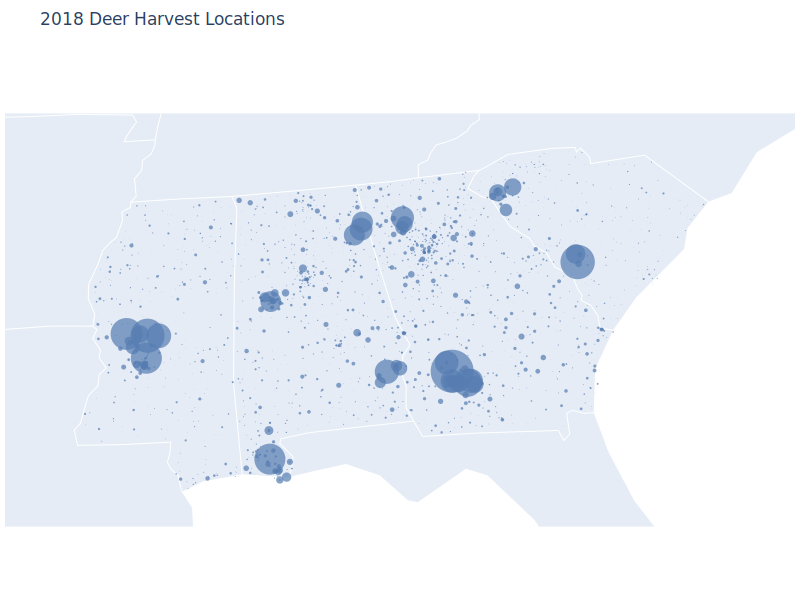

In [15]:
fig = go.Figure()
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df['lon'],
    lat = df['lat'],
    hoverinfo = 'text',
    text = df['County Name'] + ' County',
    mode = 'markers',
    marker = dict(
        size = df['harvest_count']/450,
        color = 'rgb(86, 125, 177)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.update_layout(
    geo_scope='usa',
    width=800,
    height=600,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=50,
        pad=4
    ),
    title_text ='2018 Deer Harvest Locations',
    showlegend = False,
    )
fig.update_geos(fitbounds="locations")
fig.show()

# K - MEANS WEIGHTED *** START HERE

### Define X, Y and set no of iterations

In [16]:
kmeans = KMeans(n_clusters=(no_of_clusters), random_state=0, max_iter=1000)
X = np.array(df.drop(['zip', 'Zipcode name', 'City', 'State', 'County Name','harvest_count'], 1).astype(float))
Y = np.array(df['harvest_count'].astype(float))

/var/folders/kj/vr71j0vx6873_skkn0nf_sxm0000gn/T/ipykernel_41787/98162064.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



### Run weighted k-means algorithm

In [17]:
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
centers = wt_kmeansclus.cluster_centers_

## Join clusters' lat/lon and label back onto dataframe

In [18]:
df['CLUSTER_NAME'] = predicted_kmeans
centersdf=pd.DataFrame(centers)
centersdf['CLUSTER_NAME'] = centersdf.index
centersdf=centersdf.rename(columns = {0:'CLUSTER_LAT',1:'CLUSTER_LON'})
df=df.merge(centersdf,on='CLUSTER_NAME',how='left')
df.head(3) 

,zip,Zipcode name,City,State,County Name,harvest_count,lat,lon,CLUSTER_NAME,CLUSTER_LAT,CLUSTER_LON
0,36310,"ABBEVILLE, AL",ABBEVILLE,AL,HENRY,1580.836678,31.593513,-85.228148,0,31.773248,-84.279124
1,35005,"ADAMSVILLE, AL",ADAMSVILLE,AL,JEFFERSON,376.865831,33.592857,-86.994015,2,33.606028,-87.033732
2,35540,"ADDISON, AL",ADDISON,AL,WINSTON,662.361243,34.202745,-87.204788,2,33.606028,-87.033732


## Plot results with centroids

In [ ]:
fig = go.Figure()

paths = []
for i in range(len(df)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df['CLUSTER_LON'][i], df['lon'][i]],
            lat = [df['CLUSTER_LAT'][i], df['lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'green'),
            opacity = float(df['harvest_count'][i]) / float(df['harvest_count'].max()),
        )
    )

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df['lon'],
    lat = df['lat'],
    hoverinfo = 'text',
    text = df['harvest_count'],
    mode = 'markers',
    marker = dict(
        size = df['harvest_count']/450,
        color = 'rgb(86, 125, 177)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        ) 
    )))

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df['CLUSTER_LON'],
    lat = df['CLUSTER_LAT'],
    hoverinfo = 'text',
    text = df['CLUSTER_NAME'],
    mode = 'markers',
    marker_symbol='x',
    marker = dict(
        size = 12,
        color = 'rgb(229, 75, 55)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.update_layout(
    geo_scope='usa',
    width=900,
    height=800,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=50,
        pad=4
    ),
    title_text ='Ideal Locations for Hunting Apparel Store Branches',
    showlegend = False,
    )
fig.update_geos(fitbounds="locations")
fig.show()